## Imports

In [35]:
import numpy as np 
import os
import matplotlib.pyplot as plt

## Data Load

In [36]:
healthy_path = "data/raw/healthy"
parkinson_path = "data/raw/parkinson"

output_path = "data/splits"

In [37]:
import os

def contar_archivos(carpeta):
    return len([f for f in os.listdir(carpeta) if os.path.isfile(os.path.join(carpeta, f))])

nh = contar_archivos("data/raw/Healthy")
print(f"Hay {nh}  muestras Healthy.")

np = contar_archivos("data/raw/Parkinson")
print(f"Hay {np} muestras Parkinson.")

Hay 816  muestras Healthy.
Hay 816 muestras Parkinson.


In [38]:
import os
import shutil
import random
import numpy as np
from PIL import Image

SEED = 42

def cargar_imagen(path, size=(64, 64)):
    """Carga, convierte a grises, redimensiona y aplana una imagen"""
    img = Image.open(path).convert('L').resize(size)
    return np.array(img).flatten().astype(np.float32) 

def split_dataset(healthy_dir, parkinson_dir, test_ratio=0.2, size=(64, 64), seed=SEED):
    random.seed(seed)

    # Cargar rutas
    healthy_paths = [os.path.join(healthy_dir, f) for f in os.listdir(healthy_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    parkinson_paths = [os.path.join(parkinson_dir, f) for f in os.listdir(parkinson_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Mezclar
    random.shuffle(healthy_paths)
    random.shuffle(parkinson_paths)

    # Split
    split_h = int(len(healthy_paths) * (1 - test_ratio))
    split_p = int(len(parkinson_paths) * (1 - test_ratio))

    healthy_train_paths = healthy_paths[:split_h]
    healthy_test_paths = healthy_paths[split_h:]
    parkinson_train_paths = parkinson_paths[:split_p]
    parkinson_test_paths = parkinson_paths[split_p:]

    # Cargar imágenes y etiquetas
    X_train = [cargar_imagen(p, size) for p in healthy_train_paths + parkinson_train_paths]
    y_train = [0] * len(healthy_train_paths) + [1] * len(parkinson_train_paths)

    X_test = [cargar_imagen(p, size) for p in healthy_test_paths + parkinson_test_paths]
    y_test = [0] * len(healthy_test_paths) + [1] * len(parkinson_test_paths)

    # Convertir a np.array
    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)

    X_test = np.array(X_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)

    # Mezclar train
    train = list(zip(X_train, y_train))
    random.shuffle(train)
    X_train, y_train = zip(*train)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Mezclar test
    test = list(zip(X_test, y_test))
    random.shuffle(test)
    X_test, y_test = zip(*test)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print("✅ Dataset listo para entrenar")
    print(f"   - X_train: {X_train.shape}")
    print(f"   - y_train: {y_train.shape}")
    print(f"   - X_test:  {X_test.shape}")
    print(f"   - y_test:  {y_test.shape}")

    return X_train, y_train, X_test, y_test


In [39]:
X_dev, y_dev, X_test, y_test = split_dataset(healthy_path, parkinson_path, test_ratio=0.2, seed=SEED)

✅ Dataset listo para entrenar
   - X_train: (1304, 4096)
   - y_train: (1304,)
   - X_test:  (328, 4096)
   - y_test:  (328,)


## Preprocessing

In [40]:
import numpy as np

def normalizar_dataset(X):
    """
    Recibe una lista de arrays (cada imagen) y devuelve un np.array 2D
    con los valores normalizados en el rango [0, 1].
    Output: shape (n_samples, n_features)
    """
    X_norm = [x.astype(np.float32) / 255.0 for x in X]
    return np.array(X_norm)

X_dev_normalized = normalizar_dataset(X_dev)
X_test_normalized = normalizar_dataset(X_test)


## Derivatives

In [41]:
def f_wb(x, w, b):
    return (np.tanh(np.dot(x, w) + b) + 1) / 2

def loss(X, y, w, b):
    fx = f_wb(X, w, b)
    return np.mean((fx - y)**2)

In [42]:
def gradientes(X, y, w, b):
    n = X.shape[0]
    z = np.dot(X, w) + b
    fx = (np.tanh(z) + 1) / 2

    error = fx - y
    dtanh = 0.5 * (1 - np.tanh(z)**2)

    grad_f = error * dtanh  # vector de tamaño n

    grad_w = np.dot(grad_f, X) / n
    grad_b = np.sum(grad_f) / n

    return grad_w, grad_b


In [43]:
def descenso_por_gradiente(X, y, lr=0.01, epochs=100):
    w = np.random.uniform(-0.1, 0.1, size=X.shape[1])
    b = np.random.uniform(-1, 1)


    historial_loss = []

    for epoch in range(epochs):
        grad_w, grad_b = gradientes(X, y, w, b)
        w -= lr * grad_w
        b -= lr * grad_b

        l = loss(X, y, w, b)
        historial_loss.append(l)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} - Loss: {l:.4f}")

    return w, b, historial_loss


### Training

In [44]:
w_final, b_final, historial_loss = descenso_por_gradiente(X_dev, y_dev, lr=0.001, epochs=500)

Epoch 0 - Loss: 0.5000
Epoch 10 - Loss: 0.5000
Epoch 20 - Loss: 0.5000
Epoch 30 - Loss: 0.5000
Epoch 40 - Loss: 0.5000
Epoch 50 - Loss: 0.5000
Epoch 60 - Loss: 0.5000
Epoch 70 - Loss: 0.5000
Epoch 80 - Loss: 0.5000
Epoch 90 - Loss: 0.5000
Epoch 100 - Loss: 0.5000
Epoch 110 - Loss: 0.5000
Epoch 120 - Loss: 0.5000
Epoch 130 - Loss: 0.5000
Epoch 140 - Loss: 0.5000
Epoch 150 - Loss: 0.5000
Epoch 160 - Loss: 0.5000
Epoch 170 - Loss: 0.5000
Epoch 180 - Loss: 0.5000
Epoch 190 - Loss: 0.5000
Epoch 200 - Loss: 0.5000
Epoch 210 - Loss: 0.5000
Epoch 220 - Loss: 0.5000
Epoch 230 - Loss: 0.5000
Epoch 240 - Loss: 0.5000
Epoch 250 - Loss: 0.5000
Epoch 260 - Loss: 0.5000
Epoch 270 - Loss: 0.5000
Epoch 280 - Loss: 0.5000
Epoch 290 - Loss: 0.5000
Epoch 300 - Loss: 0.5000
Epoch 310 - Loss: 0.5000
Epoch 320 - Loss: 0.5000
Epoch 330 - Loss: 0.5000
Epoch 340 - Loss: 0.5000
Epoch 350 - Loss: 0.5000
Epoch 360 - Loss: 0.5000
Epoch 370 - Loss: 0.5000
Epoch 380 - Loss: 0.5000
Epoch 390 - Loss: 0.5000
Epoch 400 -

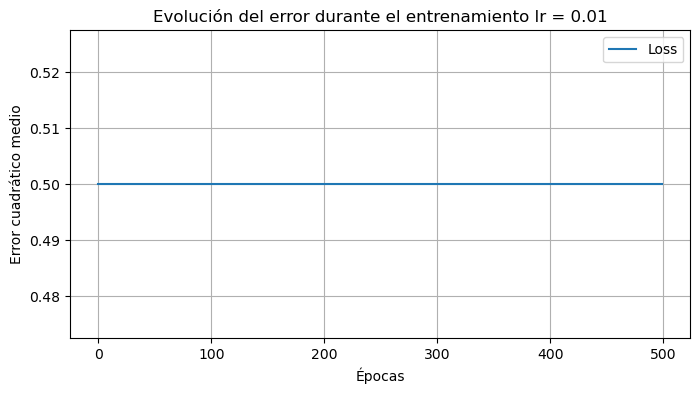

In [45]:
plt.figure(figsize=(8, 4))
plt.plot(historial_loss, label="Loss")
plt.xlabel("Épocas")
plt.ylabel("Error cuadrático medio")
plt.title("Evolución del error durante el entrenamiento lr = 0.01")
plt.grid(True)
plt.legend()
plt.show()


### Metrics on Train

In [46]:
def predecir(X, w, b):
    fx = f_wb(X, w, b)
    return (fx >= 0.5).astype(int)

def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)


In [47]:
import numpy as np

def confusion_matrix(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    
    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    return np.array([[TN, FP],
                     [FN, TP]])

import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels=["Healthy", "Parkinson"], titulo="Matriz de Confusión"):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")

    # Etiquetas
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")
    ax.set_title(titulo)

    # Anotar cada celda
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center", color="black")

    plt.colorbar(im)
    plt.show()


✅ Accuracy Train: 0.5000


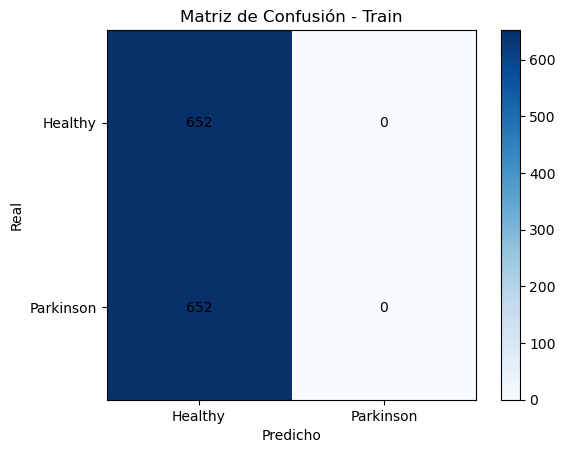

In [48]:
# Predicción
y_pred_dev = predecir(X_dev, w_final, b_final)


# Accuracy
acc_dev = accuracy(y_pred_dev, y_dev)

print(f"✅ Accuracy Train: {acc_dev:.4f}")


# Matriz de confusión
cm_dev = confusion_matrix(y_dev, y_pred_dev)

# Plot
plot_confusion_matrix(cm_dev , titulo="Matriz de Confusión - Train")

## With normalized data

In [49]:
w_final_norm, b_final_norm, historial_loss_norm = descenso_por_gradiente(X_dev_normalized, y_dev, lr=0.001, epochs=500)

Epoch 0 - Loss: 0.4999
Epoch 10 - Loss: 0.4999
Epoch 20 - Loss: 0.4999
Epoch 30 - Loss: 0.4999
Epoch 40 - Loss: 0.4999
Epoch 50 - Loss: 0.4999
Epoch 60 - Loss: 0.4999
Epoch 70 - Loss: 0.4999
Epoch 80 - Loss: 0.4999
Epoch 90 - Loss: 0.4999
Epoch 100 - Loss: 0.4999
Epoch 110 - Loss: 0.4999
Epoch 120 - Loss: 0.4999
Epoch 130 - Loss: 0.4999
Epoch 140 - Loss: 0.4999
Epoch 150 - Loss: 0.4999
Epoch 160 - Loss: 0.4999
Epoch 170 - Loss: 0.4999
Epoch 180 - Loss: 0.4999
Epoch 190 - Loss: 0.4999
Epoch 200 - Loss: 0.4999
Epoch 210 - Loss: 0.4999
Epoch 220 - Loss: 0.4999
Epoch 230 - Loss: 0.4999
Epoch 240 - Loss: 0.4999
Epoch 250 - Loss: 0.4999
Epoch 260 - Loss: 0.4999
Epoch 270 - Loss: 0.4999
Epoch 280 - Loss: 0.4999
Epoch 290 - Loss: 0.4999
Epoch 300 - Loss: 0.4999
Epoch 310 - Loss: 0.4999
Epoch 320 - Loss: 0.4999
Epoch 330 - Loss: 0.4999
Epoch 340 - Loss: 0.4999
Epoch 350 - Loss: 0.4999
Epoch 360 - Loss: 0.4999
Epoch 370 - Loss: 0.4999
Epoch 380 - Loss: 0.4999
Epoch 390 - Loss: 0.4999
Epoch 400 -

✅ Accuracy Train: 0.5000


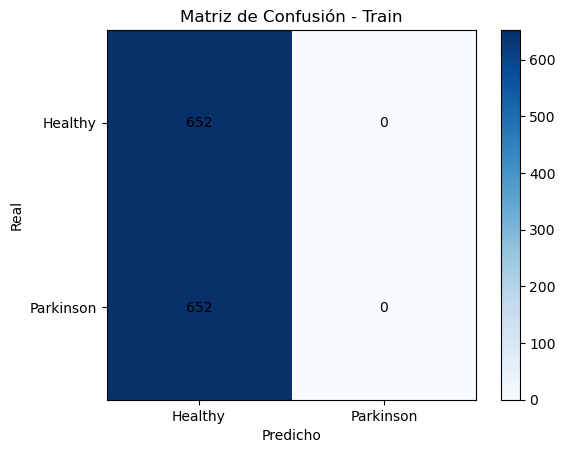

In [50]:
# Predicción
y_pred_dev_norm = predecir(X_dev_normalized, w_final_norm, b_final_norm)


# Accuracy
acc_dev_norm = accuracy(y_pred_dev_norm, y_dev)

print(f"✅ Accuracy Train: {acc_dev_norm:.4f}")


# Matriz de confusión
cm_dev_norm = confusion_matrix(y_dev, y_pred_dev_norm)

# Plot
plot_confusion_matrix(cm_dev_norm, titulo="Matriz de Confusión - Train")

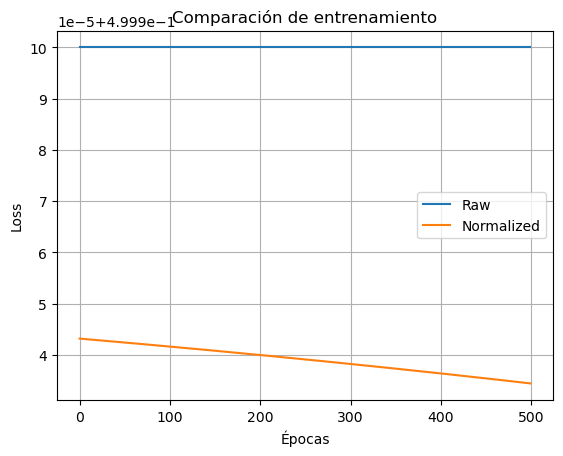

In [51]:
import matplotlib.pyplot as plt

plt.plot(historial_loss, label="Raw")
plt.plot(historial_loss_norm, label="Normalized")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Comparación de entrenamiento")
plt.legend()
plt.grid(True)
plt.show()


In [52]:
def f_wb(x, w, b):
    return (np.tanh(np.dot(x, w) + b) + 1) / 2

def loss(X, y, w, b):
    return np.mean((f_wb(X, w, b) - y) ** 2)

def gradientes(X, y, w, b):
    n = X.shape[0]
    z = np.dot(X, w) + b
    fx = (np.tanh(z) + 1) / 2
    error = fx - y
    dtanh = 0.5 * (1 - np.tanh(z)**2)
    grad_f = error * dtanh
    grad_w = np.dot(grad_f, X) / n
    grad_b = np.mean(grad_f)
    return grad_w, grad_b

# --- Descenso por gradiente ---
def descenso_por_gradiente(X, y, lr=0.01, epochs=100):
    w = np.random.uniform(-0.1, 0.1, X.shape[1])
    b = 0
    for epoch in range(epochs):
        grad_w, grad_b = gradientes(X, y, w, b)
        w -= lr * grad_w
        b -= lr * grad_b
        if epoch % 10 == 0:
            print(f"Epoch {epoch} - Loss: {loss(X, y, w, b):.4f}")
    return w, b

# --- Entrenamiento ---

w_final_n, b_final_n = descenso_por_gradiente(X_dev_normalized, y_dev, lr=0.001, epochs=200)

Epoch 0 - Loss: 0.4970
Epoch 10 - Loss: 0.4964
Epoch 20 - Loss: 0.4957
Epoch 30 - Loss: 0.4946
Epoch 40 - Loss: 0.4927
Epoch 50 - Loss: 0.4888
Epoch 60 - Loss: 0.4771
Epoch 70 - Loss: 0.3583
Epoch 80 - Loss: 0.2567
Epoch 90 - Loss: 0.2566
Epoch 100 - Loss: 0.2566
Epoch 110 - Loss: 0.2565
Epoch 120 - Loss: 0.2565
Epoch 130 - Loss: 0.2565
Epoch 140 - Loss: 0.2564
Epoch 150 - Loss: 0.2564
Epoch 160 - Loss: 0.2563
Epoch 170 - Loss: 0.2563
Epoch 180 - Loss: 0.2563
Epoch 190 - Loss: 0.2562


# **`Validación`**



usamos validaciòn para encontrar la mejor configuraciòn de hiperparàmetros. La idea es elegir un grid bastante amplio y probar las distintas configuraciones. En base a esto elegimos los hiperparametros con los que vamos a hacer el entrenamiento final

obviamente hay que chequear bien los splits y que los modelos estén bien.

In [53]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

def f_wb(x, w, b):
    return (np.tanh(np.dot(x, w) + b) + 1) / 2

def loss(X, y, w, b):
    fx = f_wb(X, w, b)
    return np.mean((fx - y)**2)

def gradientes(X, y, w, b):
    n = X.shape[0]
    z = np.dot(X, w) + b
    fx = (np.tanh(z) + 1) / 2
    error = fx - y
    dtanh = 0.5 * (1 - np.tanh(z)**2)
    grad_f = error * dtanh
    grad_w = np.dot(grad_f, X) / n
    grad_b = np.sum(grad_f) / n
    return grad_w, grad_b

def descenso_por_gradiente_early_stopping(X_train, y_train, X_val, y_val, lr=0.01, epochs=500, patience=20, seed=42):
    np.random.seed(seed)
    random.seed(seed)

    w = np.random.uniform(-0.1, 0.1, size=X_train.shape[1])
    b = np.random.uniform(-1, 1)

    best_val_loss = float('inf')
    best_w, best_b = w.copy(), b
    best_epoch = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        grad_w, grad_b = gradientes(X_train, y_train, w, b)
        w -= lr * grad_w
        b -= lr * grad_b

        train_l = loss(X_train, y_train, w, b)
        val_l = loss(X_val, y_val, w, b)

        history['train_loss'].append(train_l)
        history['val_loss'].append(val_l)

        if val_l < best_val_loss:
            best_val_loss = val_l
            best_w = w.copy()
            best_b = b
            best_epoch = epoch
        elif epoch - best_epoch >= patience:
            break

    return best_w, best_b, history, best_epoch

def accuracy(X, y, w, b):
    fx = f_wb(X, w, b)
    preds = (fx >= 0.5).astype(np.float32)
    return np.mean(preds == y)



In [54]:
# Split train en train+val (por ejemplo, 80/20)
X_train_part, X_val, y_train_part, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42)

# Normalizar los conjuntos
X_train_part = normalizar_dataset(X_train_part)
X_val = normalizar_dataset(X_val)
X_test = normalizar_dataset(X_test)

# Entrenamiento con early stopping
w, b, hist, best_epoch = descenso_por_gradiente_early_stopping(
    X_train_part, y_train_part,
    X_val, y_val,
    lr=0.01, epochs=500, patience=20, seed=42
)

# Evaluación
acc_dev = accuracy(X_train_part, y_train_part, w, b)
acc_val = accuracy(X_val, y_val, w, b)
acc_test = accuracy(X_test, y_test, w, b)

print(f"✅ Mejor época: {best_epoch}")
print(f"🔹 Accuracy train: {acc_dev:.4f}")
print(f"🔹 Accuracy val:   {acc_val:.4f}")
print(f"🔹 Accuracy test:  {acc_test:.4f}")


✅ Mejor época: 56
🔹 Accuracy train: 0.5053
🔹 Accuracy val:   0.4330
🔹 Accuracy test:  0.4146


In [55]:
import numpy as np
import random

def f_wb(x, w, b):
    return (np.tanh(np.dot(x, w) + b) + 1) / 2

def loss(X, y, w, b):
    fx = f_wb(X, w, b)
    return np.mean((fx - y)**2)

def gradientes(X, y, w, b):
    n = X.shape[0]
    z = np.dot(X, w) + b
    fx = (np.tanh(z) + 1) / 2
    error = fx - y
    dtanh = 0.5 * (1 - np.tanh(z)**2)
    grad_f = error * dtanh
    grad_w = np.dot(grad_f, X) / n
    grad_b = np.sum(grad_f) / n
    return grad_w, grad_b

def accuracy(X, y, w, b):
    fx = f_wb(X, w, b)
    preds = (fx >= 0.5).astype(np.float32)
    return np.mean(preds == y)


In [56]:
def descenso_por_gradiente_early_stopping(X_train, y_train, X_val, y_val, lr=0.01, epochs=500, patience=20, seed=42):
    np.random.seed(seed)
    random.seed(seed)

    w = np.random.uniform(-0.1, 0.1, size=X_train.shape[1])
    b = np.random.uniform(-1, 1)

    best_val_loss = float('inf')
    best_w, best_b = w.copy(), b
    best_epoch = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        grad_w, grad_b = gradientes(X_train, y_train, w, b)
        w -= lr * grad_w
        b -= lr * grad_b

        train_l = loss(X_train, y_train, w, b)
        val_l = loss(X_val, y_val, w, b)

        history['train_loss'].append(train_l)
        history['val_loss'].append(val_l)

        if val_l < best_val_loss:
            best_val_loss = val_l
            best_w = w.copy()
            best_b = b
            best_epoch = epoch
        elif epoch - best_epoch >= patience:
            break

    return best_w, best_b, history, best_epoch


In [57]:

learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
patiences = [10, 20]
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 42, 123]

resultados = []

for lr in learning_rates:
    for patience in patiences:
        for seed in seeds:

            w, b, hist, best_epoch = descenso_por_gradiente_early_stopping(
                X_train_part, y_train_part, X_val, y_val,
                lr=lr, epochs=500, patience=patience, seed=seed
            )

            acc_dev = accuracy(X_train_part, y_train_part, w, b)
            acc_val = accuracy(X_val, y_val, w, b)

            resultados.append({
                'lr': lr,
                'patience': patience,
                'seed': seed,
                'best_epoch': best_epoch,
                'acc_train': acc_dev,
                'acc_val': acc_val,
            })


In [58]:
print("Resultados de la validación:")
for res in resultados:
    print(f"LR: {res['lr']}, Patience: {res['patience']}, Seed: {res['seed']}, "
          f"Best Epoch: {res['best_epoch']}, Train Acc: {res['acc_train']:.4f}, "
          f"Val Acc: {res['acc_val']:.4f}")
    

print("El mejor resultado en validación fue con:")
best_result = max(resultados, key=lambda x: x['acc_val'])
print(f"LR: {best_result['lr']}, Patience: {best_result['patience']}, Seed: {best_result['seed']}, "
      f"Best Epoch: {best_result['best_epoch']}, Val Acc: {best_result['acc_val']:.4f}")

Resultados de la validación:
LR: 0.0001, Patience: 10, Seed: 1, Best Epoch: 95, Train Acc: 0.4899, Val Acc: 0.5287
LR: 0.0001, Patience: 10, Seed: 2, Best Epoch: 499, Train Acc: 0.4535, Val Acc: 0.5096
LR: 0.0001, Patience: 10, Seed: 3, Best Epoch: 0, Train Acc: 0.5120, Val Acc: 0.5785
LR: 0.0001, Patience: 10, Seed: 4, Best Epoch: 31, Train Acc: 0.4919, Val Acc: 0.4904
LR: 0.0001, Patience: 10, Seed: 5, Best Epoch: 30, Train Acc: 0.4765, Val Acc: 0.5134
LR: 0.0001, Patience: 10, Seed: 6, Best Epoch: 499, Train Acc: 0.4909, Val Acc: 0.5364
LR: 0.0001, Patience: 10, Seed: 7, Best Epoch: 499, Train Acc: 0.5091, Val Acc: 0.4636
LR: 0.0001, Patience: 10, Seed: 8, Best Epoch: 499, Train Acc: 0.5091, Val Acc: 0.4636
LR: 0.0001, Patience: 10, Seed: 9, Best Epoch: 499, Train Acc: 0.5091, Val Acc: 0.4521
LR: 0.0001, Patience: 10, Seed: 10, Best Epoch: 499, Train Acc: 0.5091, Val Acc: 0.4636
LR: 0.0001, Patience: 10, Seed: 11, Best Epoch: 499, Train Acc: 0.4909, Val Acc: 0.5364
LR: 0.0001, Patie

LR: 0.01, Patience: 20, Seed: 3, Best Epoch: 12, Val Acc: 0.5977


### ahora hay que entrenar con lr=best_result['lr'], seed=best_result['seed'] y la cantidad de epochs correspondientes pero con todo dev

una vez hecho esto podemos usar test para ver las métricas finles.

# TESTING CUANDO TERMINÉ EL MODELO

In [59]:

y_pred_test_n = predecir(X_test_normalized, w_final_n, b_final_n)


acc_test_n = accuracy(y_pred_test_n, y_test)
print(f"✅ Accuracy Test:  {acc_test_n:.4f}")


cm_test_n = confusion_matrix(y_test, y_pred_test_n)


plot_confusion_matrix(cm_test_n, titulo="Matriz de Confusión - Test")


TypeError: accuracy() missing 2 required positional arguments: 'w' and 'b'

cuando terminas, una recomendacion es meter las funciones en mòdulos .py segùn què son, ej models, data loading, metrics.

y los importas en el ipynb como src.metrics.